# Embeddings of unimodal  Visualization 

In [8]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv, GraphConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from dgl.data.utils import load_graphs
import argparse 
import os
import pickle
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import networkx as nx
import dgl
import logging
import torch.optim.lr_scheduler as lr_scheduler
import math

class CNN(nn.Module):
    def __init__(self, conv_param, hidden_units):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=conv_param[0][0], out_channels=conv_param[1], kernel_size=conv_param[0][1], padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=conv_param[2])
        self.flatten = nn.Flatten()
        self.input_shape = conv_param[0][2]

        # Détermination de la taille de l'entrée des couches linéaires
        num_conv_features = self._calculate_conv_features(conv_param)
        self.linear_layers = self._create_linear_layers(num_conv_features, hidden_units)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)

        # Appliquer les couches linéaires
        for layer in self.linear_layers:
            x = layer(x)
            x = self.relu(x)
        return x

   
    def _calculate_conv_features(self, conv_param):
        # Calculer le nombre de caractéristiques extraites par les couches de convolution
        dummy_input = torch.zeros((1,conv_param[0][0], *self.input_shape))  # Exemple d'entrée (taille arbitraire)
        conv_output = self.conv1(dummy_input)
        conv_output = self.relu(conv_output)
        conv_output = self.pool(conv_output)
        conv_output = self.flatten(conv_output)
        return conv_output.size(1)
       

    def _create_linear_layers(self, num_conv_features, hidden_units):
        # Créer des couches linéaires en fonction du nombre de caractéristiques extraites par les couches de convolution
        layers = []
        for i in range(len(hidden_units)):
            if i == 0:
                layers.append(nn.Linear(num_conv_features, hidden_units[i]))
            else:
                layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
        return nn.ModuleList(layers)


# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, conv_param,hidden_units):
        super(GCN, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn = CNN(conv_param=conv_param, hidden_units=hidden_units)
        #self.conv1 = SAGEConv(hidden_units[-1], hidden_size, 'mean')
        self.conv1 = SAGEConv(in_feats, hidden_size, 'mean')
        self.conv2 = SAGEConv(hidden_size, 128, 'mean')
        # Final linear layer for classification
        self.layers_1 = nn.Linear(128, 64) 
        self.layers_2 = nn.Linear(64, 32)
        self.layers_3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, g, features, edge_weights):
        #x = self.cnn(features.unsqueeze(1)).squeeze(1)
        x = self.flatten(features)  # Assuming features have already gone through CNN
        x = F.relu(self.conv1(g, x, edge_weights))
        embeddings = self.conv2(g, x, edge_weights)
        x = self.conv2(g, x, edge_weights)
        x = F.relu(self.layers_1(x)) # Logits from linear layer
        x = F.relu(self.layers_2(x)) # Logits from linear layer
        x = self.dropout(x)
        x = self.layers_3(x)
        
        
        
        return x, embeddings


            
def train(model, g, features, edge_weights, labels, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        # Forward pass
        logits,_ = model(g, features, edge_weights)
        
        # Compute loss
        loss = F.cross_entropy(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the learning rate scheduler
        scheduler.step(loss)
        
        # Log loss and optionally other metrics every 10 epochs
        if epoch % 10 == 0 or epoch==epochs:
            # You can also compute accuracy here
            _, predicted = torch.max(logits, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            
            print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%')

    return model
            


# Define a custom topological loss function
def topological_loss(embeddings, adj_matrix):
    # Calculate pairwise cosine similarity between embeddings
    cosine_sim = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    # Zero out the diagonal of the cosine similarity matrix
    cosine_sim = cosine_sim - torch.diag_embed(torch.diag(cosine_sim))
    # Compute the reconstruction loss
    reconstruction_loss = F.mse_loss(cosine_sim, adj_matrix)
    
    return reconstruction_loss

# Define the training function with topological loss
def train_with_topological_loss(model, g, features, edge_weights,adj_matrix, labels, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
   
        
        # Create a comparison matrix (1 for same labels, 0 otherwise)
     
    labels_np = labels.numpy()
    matrix = (labels_np[:, None] == labels_np[None, :]).astype(float)
    matrix = torch.tensor(matrix, dtype=torch.float32)  # Set dtype to float32
    for epoch in range(epochs):
        
        logits, embeddings = model(g, features, edge_weights)
        loss = topological_loss(embeddings, adj_matrix)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the learning rate scheduler
        scheduler.step(loss)
        
        # Log loss and optionally other metrics every 10 epochs
        if epoch % 10 == 0 or epoch==epochs:
            # You can also compute accuracy here
            _, predicted = torch.max(logits, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            
            print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%')
    return model

def train_with_topological_and_cross_loss(model, g, features, edge_weights,adj_matrix, labels, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    labels_np = labels.numpy()
    # Create the similarity matrix for topological loss
    matrix = (labels_np[:, None] == labels_np[None, :]).astype(float)
    matrix = torch.tensor(matrix, dtype=torch.float32)  # Set dtype to float32
    model.train()
    for epoch in range(epochs):
        
        logits, embeddings = model(g, features, edge_weights)
        loss = F.cross_entropy(logits, labels) + topological_loss(embeddings, adj_matrix)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the learning rate scheduler
        scheduler.step(loss)
        
        # Log loss and optionally other metrics every 10 epochs
        if epoch % 10 == 0 or epoch==epochs:
            # You can also compute accuracy here
            _, predicted = torch.max(logits, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            
            print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%')
    return model

def unsupervised_loss(embeddings, g, negative_samples=5):
    positive_loss = 0
    negative_loss = 0

    for node in range(g.number_of_nodes()):
        # Positive sampling
        neighbors = g.successors(node)
        for neighbor in neighbors:
            pos_similarity = F.cosine_similarity(embeddings[node].unsqueeze(0), embeddings[neighbor].unsqueeze(0))
            positive_loss += -torch.log(torch.sigmoid(pos_similarity))

        # Negative sampling
        for _ in range(negative_samples):
            neg_node = torch.randint(0, g.number_of_nodes(), (1,))
            neg_similarity = F.cosine_similarity(embeddings[node].unsqueeze(0), embeddings[neg_node].unsqueeze(0))
            negative_loss += -torch.log(1 - torch.sigmoid(neg_similarity))

    # Sum the losses and return a scalar
    loss = (positive_loss + negative_loss) / g.number_of_nodes()
    return loss.sum()  # Ensure that the loss is a scalar


# Define the training function with GraphSAGE-like unsupervised loss
def train_with_unsupervised_loss(model, g, features, edge_weights, negative_samples=5, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        _,embeddings = model(g, features, edge_weights)
        loss = unsupervised_loss(embeddings, g, negative_samples)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')



	
	
	

def get_homo_graph_file(dataset,unit,mma='fixed',msa='knn', input_folder='',p=0.05, w=8):
    num = math.floor(p*(unit/w -1))
    graph_file= f'saved_graphs/{dataset}/{mma}/{msa}/kws_graph_{num}_1_{unit}.dgl'


    glist, label_dict = load_graphs(os.path.join(input_folder,graph_file))
    dgl_G = glist[0]  
    return dgl_G

def get_homo_val_graph_file(dataset,unit,mma='fixed',msa='knn', add='dnn', input_folder='',p=0.05, w=8):
    num = math.floor(p*(unit/w -1))
    graph_file= f'saved_graphs/{dataset}/{mma}/{msa}/{add}/kws_graph_{num}_1_{unit}.dgl'


    glist, label_dict = load_graphs(os.path.join(input_folder,graph_file))
    dgl_G = glist[0]  
    return dgl_G

    

	

## 1.1 Unimodal graph visualization

In [22]:
!python3 gnn_model.py --input_folder ''  --graph_file saved_graphs/google_command/fixed/knn/kws_graph_187_3000.dgl --epochs 100

1612
8
/home/yannick/anaconda3/envs/gnn_acoustic/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 0, Loss: 3.3144781589508057, Accuracy: 12.17%
Epoch 10, Loss: 1.2972829341888428, Accuracy: 55.25%
Epoch 20, Loss: 0.5323175191879272, Accuracy: 88.58%
Epoch 30, Loss: 0.1600121110677719, Accuracy: 97.83%
Epoch 40, Loss: 0.045425232499837875, Accuracy: 99.38%
Epoch 50, Loss: 0.016033221036195755, Accuracy: 99.83%
Epoch 60, Loss: 0.007753285579383373, Accuracy: 99.96%
Epoch 70, Loss: 0.004740899428725243, Accuracy: 100.00%
Epoch 80, Loss: 0.00327884079888463, Accuracy: 100.00%
Epoch 90, Loss: 0.0024638876784592867, Accuracy: 100.00%
Epoch 0, Loss: 0.8162577152252197, Accuracy: 12.29%
Epoch 10, Loss: 0.1127069890499115, Accuracy: 7.75%
Epoch 20, Loss: 0.07586170732975006, Accuracy: 9.58%
Epoch

In [12]:
# Initialize the GCN model
homo_dgl = get_homo_graph_file(dataset = 'spoken_digit',unit=50, p=0.5, w=10)


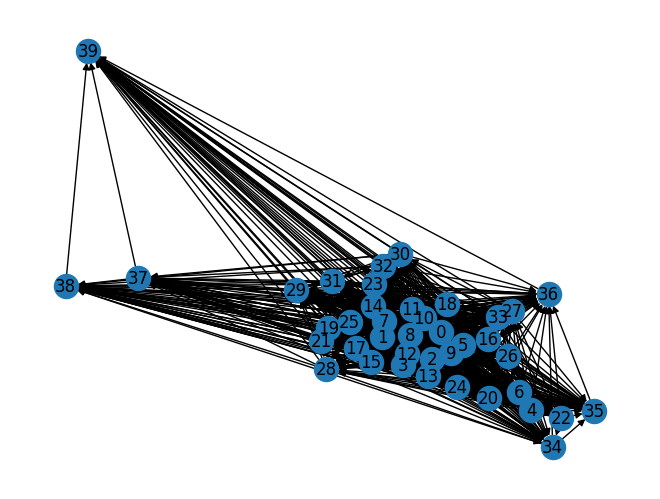

In [13]:
nx_graph = homo_dgl.to_networkx()

# Plot the NetworkX graph
nx.draw(nx_graph, with_labels=True)
plt.show()

In [ ]:
## 1.2 embedding from supervised model 

In [3]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

features = homo_dgl.ndata['feat']
labels = homo_dgl.ndata['label']
edge_weights = homo_dgl.edata['weight']
in_feats = features[0].shape[0] * features[0].shape[1]
	
	
hidden_size = 64
num_classes = len(labels.unique())  # Number of unique labels
conv_param = [
    # Parameters for the first convolutional layer
    (1, 3, (20, 64)),  # Tuple: (number of input channels, kernel size, input shape)
    32,
    # Parameters for the pooling layer
    2
]


hidden_units = [32, 32]

input_folder= 'models'
model_path = os.path.join(input_folder,"gnn_model.pth")
loaded_model_sup = GCN(in_feats, hidden_size, num_classes, conv_param, hidden_units)
loaded_model_sup.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [8]:


import torch
import dgl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
def plot_embeddings(loaded_model, graph, label_name_file, labels=None):

    # Load label names
    with open( label_name_file, 'rb') as f:
        label_name = pickle.load(f)
        
    features = homo_dgl.ndata['feat']
    if labels is None:
      labels = homo_dgl.ndata['label']
    edge_weights = homo_dgl.edata['weight']
    # Assurez-vous que votre modèle est en mode évaluation et que les gradients ne sont pas suivis
    
    with torch.no_grad():
        loaded_model.eval()
        _,node_embeddings = loaded_model_sup(graph, features, edge_weights)
        node_embeddings  = node_embeddings.numpy()
    
    # Réduire les dimensions pour le tracé avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    node_embeddings_2d = tsne.fit_transform( node_embeddings)
    
    # Supposons que label_name soit un dictionnaire ou une liste de correspondance
    # Par exemple, si label_name est un dictionnaire:
    # label_name = {0: "Classe A", 1: "Classe B", 2: "Classe C"}
    # Ou si c'est une liste:
    # label_name = ["Classe A", "Classe B", "Classe C"]
    # Assurez-vous que labels est une liste de labels numériques correspondant aux indices de label_name
    
    # Convertir les labels numériques en labels textuels
    text_labels = [label_name[label] for label in np.array(labels)]
    
    # Obtenir les labels textuels uniques
    unique_text_labels = list(set(text_labels))
    
    # Créer un dictionnaire de couleurs pour chaque label textuel unique
    colors = plt.cm.get_cmap("tab20", len(unique_text_labels))
    label_color_map = {label: colors(i) for i, label in enumerate(label_name)}
    
    # Tracer les représentations des nœuds
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(text_labels):
        plt.scatter(node_embeddings_2d[i, 0], node_embeddings_2d[i, 1], 
                    color=label_color_map[label], alpha=0.7, edgecolors='w', s=100)
    
    # Créer une légende sans doublons
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=10, label=label) for label in label_name]
    plt.legend(title='Labels', handles=handles, fontsize=14, title_fontsize=16)  # Increase font sizes
    #plt.legend(title='Labels', handles=handles)
    plt.title('Node Representations (TSNE)')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    
    plt.show()


/tmp/ipykernel_61294/1504453220.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_text_labels))


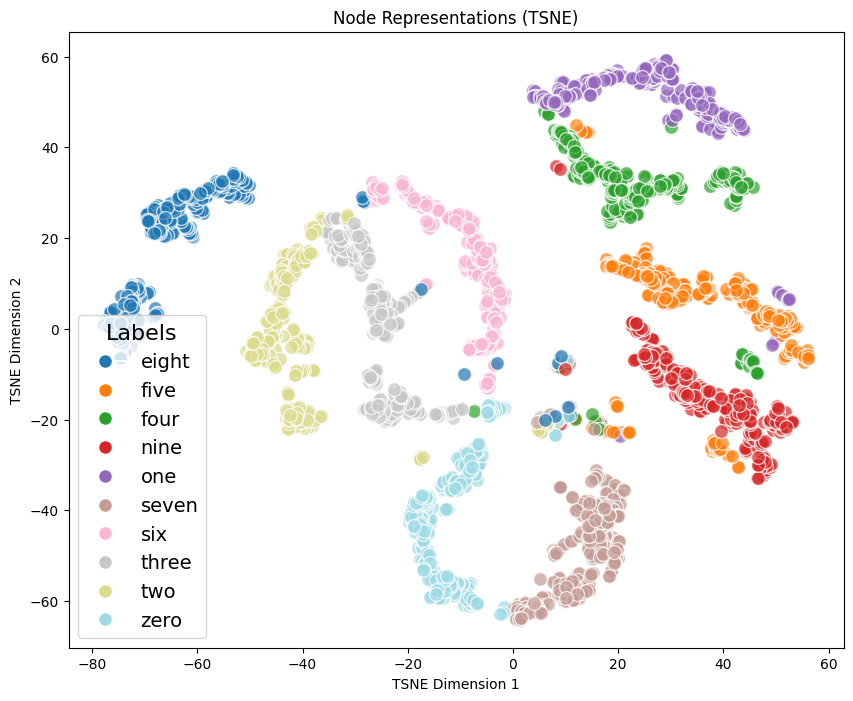

In [9]:
#label_name ={0:'down', 1:'go', 2:'left', 3:'no', 4:'right', 5:'stop' ,6:'up', 7:'yes'}
label_name ={0:'zero', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five' ,6:'six', 7:'seven', 8:'eight', 9:'nine'}
label_name_file = 'label_names_google_command.pkl'
plot_embeddings(loaded_model_sup, homo_dgl, label_name_file)

In [7]:
def get_label_val(input_folder,dataset, mma, unit):
    return np.load(os.path.join(input_folder,dataset,mma,f'subset_val_label_{unit}.npy'))
homo_val_dgl = get_homo_graph_file(dataset = 'google_command',unit=2000, p=0.5, w=8)
labels_val = get_label_val('saved_matrix','google_command','fixed',2000)
plot_embeddings(loaded_model_sup, homo_val_dgl, label_name,labels_val)

TypeError: unhashable type: 'dict'

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity

def plot_heatmap_similarity(loaded_model, graph):
    features = homo_dgl.ndata['feat']
    labels = homo_dgl.ndata['label']
    edge_weights = homo_dgl.edata['weight']
    # Assurez-vous que votre modèle est en mode évaluation et que les gradients ne sont pas suivis
    
    with torch.no_grad():
        loaded_model.eval()
        _,node_embeddings = loaded_model_sup(graph, features, edge_weights)
        node_embeddings  = node_embeddings.numpy()
   
    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(node_embeddings)
    #
    
    # Initialiser des listes pour stocker les similarités
    same_label_similarities = []
    diff_label_similarities = []
    
    # Parcourir la matrice pour séparer les similarités selon les labels
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):  # Éviter de dupliquer les paires (par ex. (i, j) et (j, i))
            if labels[i] == labels[j]:
                same_label_similarities.append(similarity_matrix[i, j])  # Même label
            else:
                diff_label_similarities.append(similarity_matrix[i, j])  # Différent label
    
    # Calculer les moyennes
    mean_same_label = np.mean(same_label_similarities)
    mean_diff_label = np.mean(diff_label_similarities)
    
    # Afficher les résultats
    print(f"Moyenne de similarité pour les éléments ayant le même label : {mean_same_label}")
    print(f"Moyenne de similarité pour les éléments ayant des labels différents : {mean_diff_label}")
    
    # Créer des histogrammes
    plt.figure(figsize=(12, 6))
    
    # Histogramme des similarités avec le même label
    plt.subplot(1, 2, 1)
    plt.hist(same_label_similarities, bins=30, color='blue', alpha=0.7)
    plt.title("Histogramme des similarités (même label)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")
    
    # Histogramme des similarités avec des labels différents
    plt.subplot(1, 2, 2)
    plt.hist(diff_label_similarities, bins=30, color='orange', alpha=0.7)
    plt.title("Histogramme des similarités (labels différents)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")
    
    # Afficher les histogrammes
    plt.tight_layout()
    plt.show()

In [35]:
from sklearn.metrics.pairwise import cosine_distances

def compute_total_inertia_cosine(loaded_model, graph):
    features = graph.ndata['feat']
    labels = graph.ndata['label'].numpy()
    edge_weights = graph.edata['weight']
    
    with torch.no_grad():
        loaded_model.eval()
        _, node_embeddings = loaded_model(graph, features, edge_weights)
        node_embeddings = node_embeddings.numpy()
    
    # Get unique labels
    unique_labels = np.unique(labels)
    total_inertia_per_label = {}

    for label in unique_labels:
        # Select embeddings corresponding to the current label
        label_indices = np.where(labels == label)[0]
        label_embeddings = node_embeddings[label_indices]
        
        # Compute the centroid for the label
        centroid = np.mean(label_embeddings, axis=0).reshape(1, -1)
        
        # Compute cosine distances from the centroid
        distances = cosine_distances(label_embeddings, centroid).flatten()
        
        # Compute total inertia as the sum of squared cosine distances
        squared_distances = distances ** 2
        total_inertia = np.sum(squared_distances)
        total_inertia_per_label[label] = total_inertia

    # Display the results
    print("Total Inertia per Label (Cosine Distance):")
    for label, inertia in total_inertia_per_label.items():
        print(f"Label {label}: Total Inertia = {inertia:.4f}")

    return total_inertia_per_label



In [43]:
from sklearn.metrics.pairwise import cosine_distances

def compute_inertie_interclasse(loaded_model, graph):
    features = graph.ndata['feat']
    labels = graph.ndata['label'].numpy()
    edge_weights = graph.edata['weight']
    
    with torch.no_grad():
        loaded_model.eval()
        _, node_embeddings = loaded_model(graph, features, edge_weights)
        node_embeddings = node_embeddings.numpy()
    
    # Get unique labels
    unique_labels = np.unique(labels)
    total_inertia_per_label = {}
    centroids = {}
    
    # Calculer l'inertie intra-classe (comme dans l'exemple précédent)
    for label in unique_labels:
        # Select embeddings corresponding to the current label
        label_indices = np.where(labels == label)[0]
        label_embeddings = node_embeddings[label_indices]
        
        # Compute the centroid for the label
        centroid = np.mean(label_embeddings, axis=0)
        centroids[label] = centroid
        
        # Compute cosine distances from the centroid
        distances = cosine_distances(label_embeddings, centroid.reshape(1, -1)).flatten()
        
        # Compute total inertia as the sum of squared cosine distances
        squared_distances = distances ** 2
        total_inertia = np.sum(squared_distances)
        total_inertia_per_label[label] = total_inertia
    
    # Calculer l'inertie interclasse
    inter_class_inertia = 0
    labels_list = list(centroids.keys())
    
    for i in range(len(labels_list)):
        for j in range(i + 1, len(labels_list)):
            label_i = labels_list[i]
            label_j = labels_list[j]
            
            # Calculer la distance cosinus entre les centroïdes des classes i et j
            distance = cosine_distances([centroids[label_i]], [centroids[label_j]])[0][0]
            
            # L'inertie interclasse est la somme des distances cosinus au carré
            inter_class_inertia += distance ** 2
    
    # Afficher les résultats
    print("Inertie intra-classe (Cosine Distance):")
    for label, inertia in total_inertia_per_label.items():
        print(f"Label {label}: Inertie = {inertia:.4f}")
    
    print(f"Inertie inter-classe (Cosine Distance) : {inter_class_inertia:.4f}")

    return total_inertia_per_label, inter_class_inertia


In [47]:
from sklearn.metrics.pairwise import cosine_distances

def compute_total_inertia(loaded_model, graph):
    features = graph.ndata['feat']
    labels = graph.ndata['label'].numpy()
    edge_weights = graph.edata['weight']
    
    with torch.no_grad():
        loaded_model.eval()
        _, node_embeddings = loaded_model(graph, features, edge_weights)
        node_embeddings = node_embeddings.numpy()
    
    # Get unique labels
    unique_labels = np.unique(labels)
    total_inertia_per_label = {}
    intra_class_inertia = 0  # Variable pour stocker l'inertie intra-classe totale
    centroids = {}

    # Calculer l'inertie intra-classe et l'inertie par label
    for label in unique_labels:
        # Select embeddings corresponding to the current label
        label_indices = np.where(labels == label)[0]
        label_embeddings = node_embeddings[label_indices]
        
        # Compute the centroid for the label
        centroid = np.mean(label_embeddings, axis=0)
        centroids[label] = centroid
        
        # Compute cosine distances from the centroid
        distances = cosine_distances(label_embeddings, centroid.reshape(1, -1)).flatten()
        
        # Inertie intra-classe pour ce label
        squared_distances = distances ** 2
        total_inertia = np.sum(squared_distances)
        total_inertia_per_label[label] = total_inertia
        
        # Ajouter à l'inertie intra-classe totale
        intra_class_inertia += total_inertia
    
    # Calculer l'inertie inter-classe
    inter_class_inertia = 0
    labels_list = list(centroids.keys())
    
    for i in range(len(labels_list)):
        for j in range(i + 1, len(labels_list)):
            label_i = labels_list[i]
            label_j = labels_list[j]
            
            # Calculer la distance cosinus entre les centroïdes des classes i et j
            distance = cosine_distances([centroids[label_i]], [centroids[label_j]])[0][0]
            
            # L'inertie interclasse est la somme des distances cosinus au carré
            inter_class_inertia += distance ** 2
    
    # Afficher les résultats
    print("Inertie intra-classe (Cosine Distance):")
    for label, inertia in total_inertia_per_label.items():
        print(f"Label {label}: Inertie = {inertia:.4f}")
    
    print(f"Inertie intra-classe totale (Cosine Distance) : {intra_class_inertia:.4f}")
    print(f"Inertie inter-classe (Cosine Distance) : {inter_class_inertia:.4f}")

    return total_inertia_per_label, intra_class_inertia, inter_class_inertia


Moyenne de similarité pour les éléments ayant le même label : 0.9733970761299133
Moyenne de similarité pour les éléments ayant des labels différents : 0.952437698841095


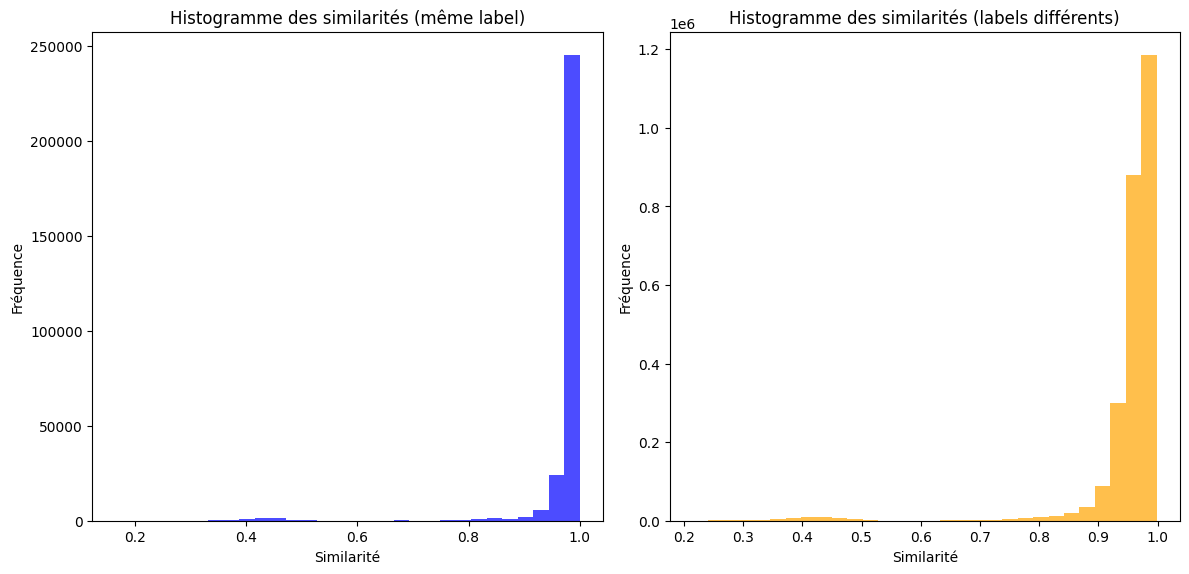

In [113]:
plot_heatmap_similarity(loaded_model_sup, homo_dgl)

In [48]:
compute_total_inertia(loaded_model_sup, homo_dgl)

Inertie intra-classe (Cosine Distance):
Label 0: Inertie = 0.8824
Label 1: Inertie = 0.9369
Label 2: Inertie = 0.5006
Label 3: Inertie = 1.1765
Label 4: Inertie = 0.4421
Label 5: Inertie = 0.2077
Label 6: Inertie = 0.5748
Label 7: Inertie = 0.7854
Inertie intra-classe totale (Cosine Distance) : 5.5064
Inertie inter-classe (Cosine Distance) : 0.1085


({0: 0.88242716,
  1: 0.9368866,
  2: 0.50060326,
  3: 1.1765146,
  4: 0.44208267,
  5: 0.20768999,
  6: 0.57479477,
  7: 0.7854278},
 5.506426885724068,
 0.10845658119809443)

## 1.3 Embeddings from unsupervised model

In [10]:
model_path = os.path.join(input_folder,"gnn_model_hibrid.pth")
loaded_model_unsup = GCN(in_feats, hidden_size, num_classes, conv_param, hidden_units)
loaded_model_unsup.load_state_dict(torch.load(model_path))


<All keys matched successfully>

/tmp/ipykernel_61294/1504453220.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_text_labels))


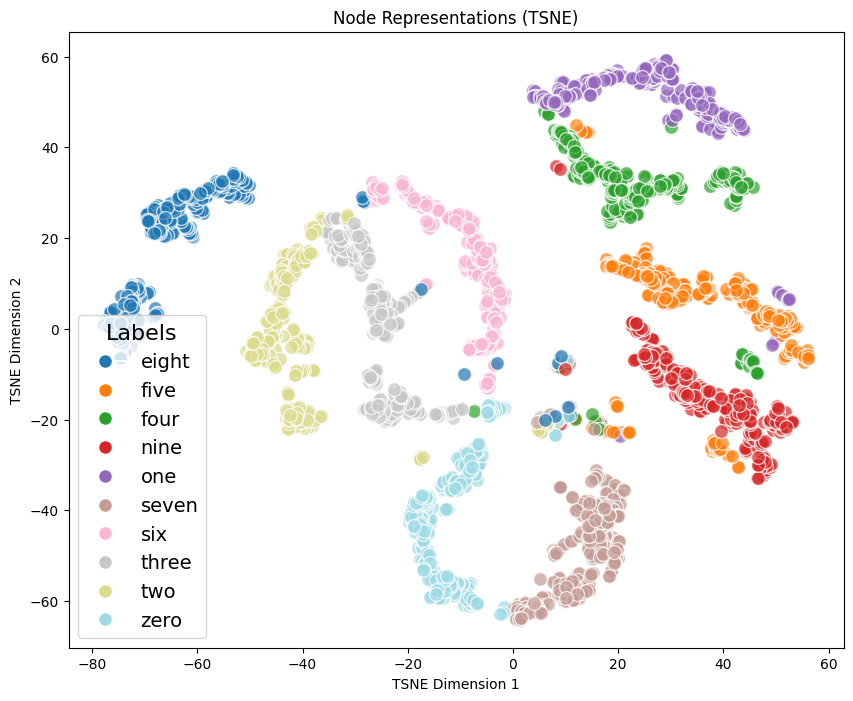

In [11]:
#label_name ={0:'down', 1:'go', 2:'left', 3:'no', 4:'right', 5:'stop' ,6:'up', 7:'yes'}
label_name ={0:'zero', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five' ,6:'six', 7:'seven', 8:'eight', 9:'nine'}
plot_embeddings(loaded_model_unsup, homo_dgl, label_name_file)

/tmp/ipykernel_4143/3086636284.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_text_labels))


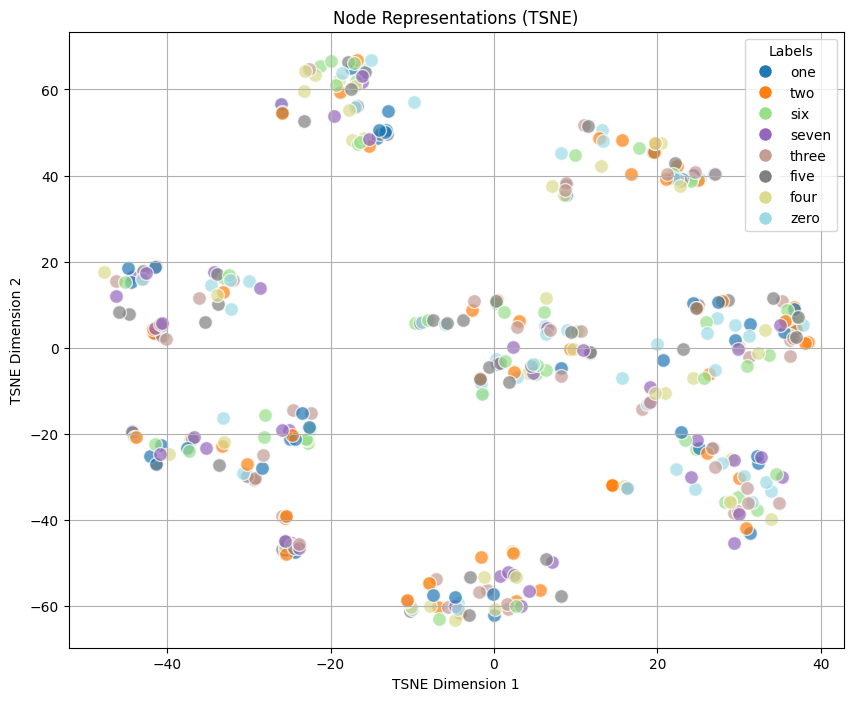

In [21]:
plot_embeddings(loaded_model_unsup, homo_val_dgl, label_name,labels_val)

Moyenne de similarité pour les éléments ayant le même label : 0.9733970761299133
Moyenne de similarité pour les éléments ayant des labels différents : 0.952437698841095


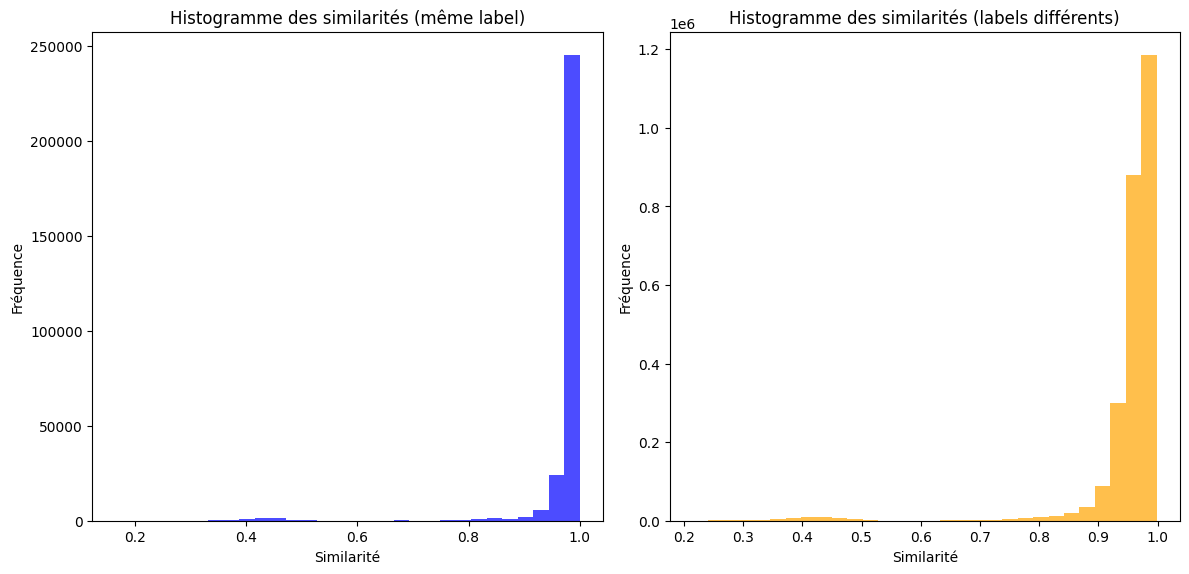

In [116]:
plot_heatmap_similarity(loaded_model_unsup, homo_dgl)

In [42]:
inertia_dic = compute_total_inertia(loaded_model_unsup, homo_dgl)
T=0
n_word = len(inertia_dic)
for label, inertia in inertia_dic.items():
    T+=inertia
T=T/n_word
print(f"Total intraclasse Inertia = {T:.4f}")

Total Inertia per Label:
Label 0: Total Inertia = 3438185.2500
Label 1: Total Inertia = 2707645.2500
Label 2: Total Inertia = 2904128.0000
Label 3: Total Inertia = 2911564.2500
Label 4: Total Inertia = 2865237.7500
Label 5: Total Inertia = 2555766.5000
Label 6: Total Inertia = 2645694.0000
Label 7: Total Inertia = 2849049.0000
Total intraclasse Inertia = 2859658.7500


In [45]:
compute_inertie_interclasse(loaded_model_unsup, homo_dgl)

Inertie intra-classe (Cosine Distance):
Label 0: Inertie = 15.9630
Label 1: Inertie = 23.8024
Label 2: Inertie = 23.7564
Label 3: Inertie = 27.3620
Label 4: Inertie = 16.1807
Label 5: Inertie = 12.2511
Label 6: Inertie = 19.4289
Label 7: Inertie = 9.8013
Inertie inter-classe (Cosine Distance) : 24.4257


({0: 15.962987,
  1: 23.802402,
  2: 23.756351,
  3: 27.362026,
  4: 16.180746,
  5: 12.251138,
  6: 19.42886,
  7: 9.801268},
 24.425662473924493)

In [117]:
compute_total_inertia(loaded_model_unsup, homo_dgl)

Inertie intra-classe (Cosine Distance):
Label 0: Inertie = 2.5568
Label 1: Inertie = 2.2389
Label 2: Inertie = 2.2574
Label 3: Inertie = 2.8548
Label 4: Inertie = 2.6638
Label 5: Inertie = 2.3935
Label 6: Inertie = 1.9404
Label 7: Inertie = 2.4339
Label 8: Inertie = 3.0802
Label 9: Inertie = 1.8615
Inertie intra-classe totale (Cosine Distance) : 24.2811
Inertie inter-classe (Cosine Distance) : 0.9495


({0: 2.5568495,
  1: 2.2389164,
  2: 2.257429,
  3: 2.854782,
  4: 2.663763,
  5: 2.3934593,
  6: 1.9403776,
  7: 2.4338672,
  8: 3.0801911,
  9: 1.8614765},
 24.28111171722412,
 0.949470902661087)

# Embedding of multimodal visualisation

In [16]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import HeteroGraphConv, GraphConv, SAGEConv
import argparse 
import os
import networkx as nx
import logging
from torch.optim import lr_scheduler

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Define the HeteroGCN model
# Define the HeteroGCN model with additional linear layers
class HeteroGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats, linear_hidden_size):
        super(HeteroGCN, self).__init__()
        
        # Graph convolutional layers
        self.conv1 = HeteroGraphConv({
            'sim_tic': SAGEConv(in_feats['acoustic'], hidden_size, 'mean'),
            'sim_w': SAGEConv(in_feats['word'], hidden_size, 'mean'),
            'related_to': SAGEConv(in_feats['acoustic'], hidden_size, 'mean')
        }, aggregate='mean')
        
        self.conv2 = HeteroGraphConv({
            'sim_tic': SAGEConv(hidden_size, 128, 'mean'),
            'sim_w': SAGEConv(hidden_size, 128, 'mean'),
            'related_to': SAGEConv(hidden_size, 128, 'mean')
        }, aggregate='mean')
        
        # Three linear layers
        self.linear1 = nn.Linear(128, linear_hidden_size)
        self.linear2 = nn.Linear(linear_hidden_size, 32)
        self.linear3 = nn.Linear(32, out_feats)
        self.dropout = nn.Dropout(0.5)

    def forward(self, g, inputs):
        # Get edge weights
        edge_weights = {etype: g.edges[etype].data['weight'] for etype in g.etypes}
        
        # Graph convolution layers
        h = self.conv1(g, inputs, mod_kwargs={k: {'edge_weight': v} for k, v in edge_weights.items()})
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(g, h, mod_kwargs={k: {'edge_weight': v} for k, v in edge_weights.items()})
        embeddings = h
        # Process each node type separately through linear layers
        h['acoustic'] = F.relu(self.linear1(h['acoustic']))
        h['acoustic'] = F.relu(self.linear2(h['acoustic']))
        h['acoustic'] = self.dropout(h['acoustic'])
        h['acoustic'] = self.linear3(h['acoustic'])
        
        
        
        return h['acoustic'],embeddings


# Define a custom topological loss function
def topological_loss(embeddings_acoustic, embeddings_word, adj_matrix_acoustic, adj_matrix_word, adj_matrix_acoustic_word):
    # Calculate pairwise cosine similarity between embeddings
    cosine_sim_acoustic = F.cosine_similarity(embeddings_acoustic.unsqueeze(1), embeddings_acoustic.unsqueeze(0), dim=2)
    cosine_sim_word = F.cosine_similarity(embeddings_word.unsqueeze(1), embeddings_word.unsqueeze(0), dim=2)
    
    # Zero out the diagonal of the cosine similarity matrices
    cosine_sim_acoustic = cosine_sim_acoustic - torch.diag_embed(torch.diag(cosine_sim_acoustic))
    #cosine_sim_word = cosine_sim_word - torch.diag_embed(torch.diag(cosine_sim_word))
    
    # Compute the reconstruction loss for intra-type connections
    reconstruction_loss_acoustic = F.mse_loss(cosine_sim_acoustic, adj_matrix_acoustic)
    #reconstruction_loss_word = F.mse_loss(cosine_sim_word, adj_matrix_word)
    
    # Compute the reconstruction loss for inter-type connections
    #reconstruction_loss_acoustic_word = F.mse_loss(
    #    torch.matmul(embeddings_acoustic, embeddings_word.t()),
    #    adj_matrix_acoustic_word
    #)
    
    return reconstruction_loss_acoustic 

# Define the training function with topological loss
def train_with_topological_loss(model, g, features, adj_matrix_acoustic, adj_matrix_word, adj_matrix_acoustic_word, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        _,embeddings = model(g, features)
        loss = topological_loss(
            embeddings['acoustic'], embeddings['word'], 
            adj_matrix_acoustic, adj_matrix_word, adj_matrix_acoustic_word
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')



# Define the training function with topological loss for heterogeneous graph
def train_with_topological_loss_cross_loss(model, g, features, adj_matrix_acoustic, adj_matrix_word, adj_matrix_acoustic_word, labels, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
   
    
    
    for epoch in range(epochs):
        # Forward pass: Get the logits and embeddings from the model
        embeddings = model(g, features)
        
        # Topological loss computation for each node type
        
        logits, embeddings = model(g, features)
        loss = F.cross_entropy(logits, labels) + topological_loss( embeddings['acoustic'], embeddings['word'], adj_matrix_acoustic, adj_matrix_word, adj_matrix_acoustic_word)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the learning rate scheduler
        scheduler.step(loss)
        
        # Log loss and optionally other metrics every 10 epochs
        if epoch % 10 == 0 or epoch==epochs:
            # You can also compute accuracy here
            _, predicted = torch.max(logits, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            
            print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%')
    
    return model

# Main function to load graph, prepare data, and train model

def main(input_folder, graph_file, epochs):
    # Load the heterogeneous graph
    glist, _ = dgl.load_graphs(os.path.join(input_folder, graph_file))
    hetero_graph = glist[0]
    
    # Extract features
    features = {
        'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
        'word': hetero_graph.nodes['word'].data['feat']
    }
    labels = hetero_graph.nodes['acoustic'].data['label']
    # Initialize the HeteroGCN model
    in_feats = {'acoustic': features['acoustic'].shape[1], 'word': features['word'].shape[1]}
    hidden_size = 512
    linear_hidden_size = 64  # Set linear hidden size
    out_feats = len(labels.unique())  # Set output feature size
    model = HeteroGCN(in_feats, hidden_size, out_feats, linear_hidden_size)
    
    # Extract adjacency matrices and other training details (unchanged)
    adj_matrix_acoustic = torch.tensor(nx.to_numpy_matrix(hetero_graph['acoustic', 'sim_tic', 'acoustic'].to_networkx()))
    adj_matrix_word = torch.tensor(nx.to_numpy_matrix(hetero_graph['word', 'sim_w', 'word'].to_networkx()))
    num_acoustic_nodes = hetero_graph.num_nodes('acoustic')
    num_word_nodes = hetero_graph.num_nodes('word')
    adj_matrix_acoustic_word = torch.zeros(num_acoustic_nodes, num_word_nodes)
    src, dst = hetero_graph.edges(etype=('acoustic', 'related_to', 'word'))
    adj_matrix_acoustic_word[src, dst] = 1 

    # Convert matrices to float
    adj_matrix_acoustic = adj_matrix_acoustic.float()
    adj_matrix_word = adj_matrix_word.float()
    adj_matrix_acoustic_word = adj_matrix_acoustic_word.float()
    features = {k: v.float() for k, v in features.items()}
    
    # Train the model
    model = train_with_topological_loss_cross_loss(
        model, hetero_graph, features, 
        adj_matrix_acoustic, adj_matrix_word, adj_matrix_acoustic_word,labels,
        epochs
    )
    
    # Save the model
    model_path = os.path.join('models', "hetero_gnn_model.pth")
    torch.save(model.state_dict(), model_path)
    logging.info(f'Model saved to {model_path}')




In [17]:
import math
def get_hetero_graph_file(dataset,unit,mhg,msw='phon_count', mma='fixed',msa='knn',input_folder='',pa=0.5,ph=0.5,w=8):
    num = math.floor(pa*(unit/w-1))
    num_n_h = math.floor(num/4)
    graph_file= f'saved_graphs/{dataset}/{mma}/{msa}/{mhg}/{msw}/hetero_graph_{num}_{num_n_h}_{unit}.dgl'

    glist, label_dict = load_graphs(os.path.join(input_folder,graph_file))
    dgl_G = glist[0]  
    return dgl_G

def get_hetero_val_graph_file(dataset,unit,mhg,msw='phon_count', mma='fixed',msa='knn',add='dnn',input_folder='',pa=0.05, ph=0.05,w=8):
   
    num = math.floor(pa*(unit/w-1))
    num_n_h = num/4
    graph_file= f'saved_graphs/{dataset}/{mma}/{msa}/{mhg}/{msw}/{add}/hetero_graph_val_{add}_{num}_{num_n_h}_{unit}.dgl'

    glist, label_dict = load_graphs(os.path.join(input_folder,graph_file))
    dgl_G = glist[0]  
    return dgl_G
    
# Function to load the model and graph, get representations, and plot them
def load_and_plot_model(hetero_graph, model_folder, label_name_file, labels=None):

    # Load label names
    with open( label_name_file, 'rb') as f:
        label_names = pickle.load(f)

    # Get labels and convert them to strings
    if labels is None:
       labels = hetero_graph.nodes['acoustic'].data['label']
    label_strings = [label_names[int(label)] for label in labels]
    
    # Load the heterogeneous GCN model
    features_dic = {
        'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
        'word': hetero_graph.nodes['word'].data['feat']
    }
    in_feats = {'acoustic': features_dic['acoustic'].shape[1], 'word': features_dic['word'].shape[1]}
    hidden_size = 512
    linear_hidden_size = 64
    if labels is None:
       out_feats = len(labels.unique())
    else:
       out_feats = len(np.unique(labels))
    
    # Initialize the model
    model = HeteroGCN(in_feats, hidden_size, out_feats, linear_hidden_size)
    #model_sage = HeteroGCN(in_feats, hidden_size, out_feats)
    # Load the pre-trained model state
    model.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model.pth")))
    model.eval()
    
    #model_sage.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model_unsupervised.pth")))
    #model_sage.eval()
    # Extract acoustic node representations
    logging.info(f'Extract acoustic node representations')
    with torch.no_grad():
        _,embeddings = model(hetero_graph, features_dic)
        acoustic_embeddings = embeddings['acoustic']

    

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2)
    acoustic_embeddings_2d = tsne.fit_transform(acoustic_embeddings)
    
    # Créer un dictionnaire de couleurs pour chaque label textuel unique
    colors = plt.cm.get_cmap("tab20", len(label_names))
    label_color_map = {label: colors(i) for i, label in enumerate(label_names)}
    
    # Tracer les représentations des nœuds
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(label_strings):
        plt.scatter(acoustic_embeddings_2d[i,0], acoustic_embeddings_2d[i,1], 
                    color=label_color_map[label], alpha=0.7, edgecolors='w', s=100)
    
    # Créer une légende sans doublons
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=10, label=label) for label in label_names]
    #plt.legend(title='Labels', handles=handles)
    plt.legend(title='Labels', handles=handles, fontsize=14, title_fontsize=16)  # Increase font sizes
    # Plot the acoustic node representations
    #plt.figure(figsize=(10, 8))
    #for label in set(label_strings):
        
    #      indices = [i for i, l in enumerate(label_strings) if l == label]
    #      plt.scatter(acoustic_embeddings_2d[indices, 0], acoustic_embeddings_2d[indices, 1], label=label, alpha=0.7,edgecolors='w', s=100)
    
    #plt.legend()
    plt.title('Acoustic Node Representations')
    plt.show()

def plot_heatmap_similarity_hetero(hetero_graph, model_folder):
   
    # Get labels and convert them to strings
    labels = hetero_graph.nodes['acoustic'].data['label']
    
    # Load the heterogeneous GCN model
    features_dic = {
        'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
        'word': hetero_graph.nodes['word'].data['feat']
    }
    in_feats = {'acoustic': features_dic['acoustic'].shape[1], 'word': features_dic['word'].shape[1]}
    hidden_size = 512
    linear_hidden_size = 64
    if labels is None:
       out_feats = len(labels.unique())
    else:
       out_feats = len(np.unique(labels))
    
    # Initialize the model
    model = HeteroGCN(in_feats, hidden_size, out_feats, linear_hidden_size)
    #model_sage = HeteroGCN(in_feats, hidden_size, out_feats)
    # Load the pre-trained model state
    model.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model.pth")))
    model.eval()
    
    #model_sage.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model_unsupervised.pth")))
    #model_sage.eval()
    # Extract acoustic node representations
    logging.info(f'Extract acoustic node representations')
    with torch.no_grad():
        _,embeddings = model(hetero_graph, features_dic)
        acoustic_embeddings = embeddings['acoustic']
   
    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(acoustic_embeddings)
    #
    
    # Initialiser des listes pour stocker les similarités
    same_label_similarities = []
    diff_label_similarities = []
    
    # Parcourir la matrice pour séparer les similarités selon les labels
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):  # Éviter de dupliquer les paires (par ex. (i, j) et (j, i))
            if labels[i] == labels[j]:
                same_label_similarities.append(similarity_matrix[i, j])  # Même label
            else:
                diff_label_similarities.append(similarity_matrix[i, j])  # Différent label
    
    # Calculer les moyennes
    mean_same_label = np.mean(same_label_similarities)
    mean_diff_label = np.mean(diff_label_similarities)
    
    # Afficher les résultats
    print(f"Moyenne de similarité pour les éléments ayant le même label : {mean_same_label}")
    print(f"Moyenne de similarité pour les éléments ayant des labels différents : {mean_diff_label}")
    
    # Créer des histogrammes
    plt.figure(figsize=(12, 6))
    
    # Histogramme des similarités avec le même label
    plt.subplot(1, 2, 1)
    plt.hist(same_label_similarities, bins=30, color='blue', alpha=0.7)
    plt.title("Histogramme des similarités (même label)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")
    
    # Histogramme des similarités avec des labels différents
    plt.subplot(1, 2, 2)
    plt.hist(diff_label_similarities, bins=30, color='orange', alpha=0.7)
    plt.title("Histogramme des similarités (labels différents)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")
    
    # Afficher les histogrammes
    plt.tight_layout()
    plt.show()

In [18]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

def plot_heatmap_similarity_hetero(hetero_graph, model_folder):
    # Get labels and convert them to numpy format
    labels = hetero_graph.nodes['acoustic'].data['label'].cpu().numpy()
    
    # Load the heterogeneous GCN model
    features_dic = {
        'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
        'word': hetero_graph.nodes['word'].data['feat']
    }
    in_feats = {
        'acoustic': features_dic['acoustic'].shape[1],
        'word': features_dic['word'].shape[1]
    }
    hidden_size = 512
    linear_hidden_size = 64
    out_feats = len(np.unique(labels))  # Unique labels define the output dimension
    
    # Initialize and load the pre-trained model
    model = HeteroGCN(in_feats, hidden_size, out_feats, linear_hidden_size)
    model.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model.pth")))
    model.eval()

    # Extract acoustic node representations
    print(f'Extracting acoustic node representations...')
    with torch.no_grad():
        _, embeddings = model(hetero_graph, features_dic)
        acoustic_embeddings = embeddings['acoustic'].cpu().numpy()

    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(acoustic_embeddings)

    # Initialize lists to store similarities
    same_label_similarities = []
    diff_label_similarities = []

    # Separate similarities based on labels
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):  # Avoid duplicate pairs
            if labels[i] == labels[j]:
                same_label_similarities.append(similarity_matrix[i, j])  # Same label
            else:
                diff_label_similarities.append(similarity_matrix[i, j])  # Different labels

    # Compute means
    mean_same_label = np.mean(same_label_similarities)
    mean_diff_label = np.mean(diff_label_similarities)

    # Compute total inertia per label using cosine distance
    total_inertia_per_label = {}
    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Get the embeddings for the current label
        label_embeddings = acoustic_embeddings[labels == label]
        
        # Compute the centroid for the current label
        centroid = np.mean(label_embeddings, axis=0).reshape(1, -1)
        
        # Compute the cosine distances to the centroid
        distances = cosine_distances(label_embeddings, centroid)
        
        # Compute total inertia as the sum of squared cosine distances
        inertia = np.sum(distances ** 2)
        total_inertia_per_label[label] = inertia

    # Display results
    print(f"Moyenne de similarité pour les éléments ayant le même label : {mean_same_label:.4f}")
    print(f"Moyenne de similarité pour les éléments ayant des labels différents : {mean_diff_label:.4f}")
    print("\nTotal Inertia per Label (Cosine Distance):")
    for label, inertia in total_inertia_per_label.items():
        print(f"Label {label}: {inertia:.4f}")

    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Similarities for same labels
    plt.subplot(1, 2, 1)
    plt.hist(same_label_similarities, bins=30, color='blue', alpha=0.7)
    plt.title("Histogramme des similarités (même label)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")

    # Similarities for different labels
    plt.subplot(1, 2, 2)
    plt.hist(diff_label_similarities, bins=30, color='orange', alpha=0.7)
    plt.title("Histogramme des similarités (labels différents)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")

    # Show histograms
    plt.tight_layout()
    plt.show()

    return total_inertia_per_label


In [19]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import logging

def plot_heatmap_similarity_hetero(hetero_graph, model_folder):
    # Get labels and convert them to numpy format
    labels = hetero_graph.nodes['acoustic'].data['label'].cpu().numpy()
    
    # Load the heterogeneous GCN model
    features_dic = {
        'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
        'word': hetero_graph.nodes['word'].data['feat']
    }
    in_feats = {
        'acoustic': features_dic['acoustic'].shape[1],
        'word': features_dic['word'].shape[1]
    }
    hidden_size = 512
    linear_hidden_size = 64
    out_feats = len(np.unique(labels))  # Unique labels define the output dimension
    
    # Initialize and load the pre-trained model
    model = HeteroGCN(in_feats, hidden_size, out_feats, linear_hidden_size)
    model.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model.pth")))
    model.eval()

    # Extract acoustic node representations
    print(f'Extracting acoustic node representations...')
    with torch.no_grad():
        _, embeddings = model(hetero_graph, features_dic)
        acoustic_embeddings = embeddings['acoustic'].cpu().numpy()

    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(acoustic_embeddings)

    # Initialize lists to store similarities
    same_label_similarities = []
    diff_label_similarities = []

    # Separate similarities based on labels
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):  # Avoid duplicate pairs
            if labels[i] == labels[j]:
                same_label_similarities.append(similarity_matrix[i, j])  # Same label
            else:
                diff_label_similarities.append(similarity_matrix[i, j])  # Different labels

    # Compute means
    mean_same_label = np.mean(same_label_similarities)
    mean_diff_label = np.mean(diff_label_similarities)

    # Compute total inertia per label using cosine distance
    total_inertia_per_label = {}
    intraclass_inertia = {}
    interclass_inertia = {}

    unique_labels = np.unique(labels)
    for label in unique_labels:
        # Get the embeddings for the current label
        label_embeddings = acoustic_embeddings[labels == label]
        
        # Compute the centroid for the current label
        centroid = np.mean(label_embeddings, axis=0).reshape(1, -1)
        
        # Compute the cosine distances to the centroid for intraclass inertia
        distances = cosine_distances(label_embeddings, centroid)
        inertia = np.sum(distances ** 2)  # Intraclass inertia
        intraclass_inertia[label] = inertia

        # Store the total inertia for each label
        total_inertia_per_label[label] = inertia

    # Compute interclass inertia (distance between centroids of different classes)
    total_interclass_inertia = 0
    for i, label_i in enumerate(unique_labels):
        centroid_i = np.mean(acoustic_embeddings[labels == label_i], axis=0).reshape(1, -1)
        for j, label_j in enumerate(unique_labels):
            if i < j:  # Only compute for pairs of distinct labels
                centroid_j = np.mean(acoustic_embeddings[labels == label_j], axis=0).reshape(1, -1)
                interclass_distance = cosine_distances(centroid_i, centroid_j)
                interclass_inertia[(label_i, label_j)] = np.sum(interclass_distance ** 2)
                total_interclass_inertia += np.sum(interclass_distance ** 2)  # Total interclass inertia

    # Compute total intraclass inertia
    total_intraclass_inertia = np.sum(list(intraclass_inertia.values()))

    # Display results
    print(f"Moyenne de similarité pour les éléments ayant le même label : {mean_same_label:.4f}")
    print(f"Moyenne de similarité pour les éléments ayant des labels différents : {mean_diff_label:.4f}")
    print("\nTotal Inertia per Label (Cosine Distance):")
    for label, inertia in total_inertia_per_label.items():
        print(f"Label {label}: Total Inertia (Intraclass) = {inertia:.4f}")

    print("\nInterclass Inertia (Cosine Distance) between centroids:")
    for (label_i, label_j), inertia in interclass_inertia.items():
        print(f"Interclass Inertia between Label {label_i} and Label {label_j}: {inertia:.4f}")

    print(f"\nTotal Intraclass Inertia (Cosine Distance): {total_intraclass_inertia:.4f}")
    print(f"Total Interclass Inertia (Cosine Distance): {total_interclass_inertia:.4f}")

    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Similarities for same labels
    plt.subplot(1, 2, 1)
    plt.hist(same_label_similarities, bins=30, color='blue', alpha=0.7)
    plt.title("Histogramme des similarités (même label)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")

    # Similarities for different labels
    plt.subplot(1, 2, 2)
    plt.hist(diff_label_similarities, bins=30, color='orange', alpha=0.7)
    plt.title("Histogramme des similarités (labels différents)")
    plt.xlabel("Similarité")
    plt.ylabel("Fréquence")

    # Show histograms
    plt.tight_layout()
    plt.show()

    return total_inertia_per_label, intraclass_inertia, interclass_inertia, total_intraclass_inertia, total_interclass_inertia


In [105]:
!python gnn_heto_model.py --input_folder '' --graph_file saved_graphs/spoken_digit/fixed/knn/dnn/phon_count/hetero_graph_149_37_3000.dgl --epochs 100

/home/yannick/anaconda3/envs/gnn_acoustic/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 0, Loss: 24.808364868164062, Accuracy: 10.08%
Epoch 10, Loss: 8.9774169921875, Accuracy: 10.08%
Epoch 20, Loss: 3.870800018310547, Accuracy: 13.21%
Epoch 30, Loss: 2.8693151473999023, Accuracy: 9.67%
Epoch 40, Loss: 3.118671178817749, Accuracy: 12.88%
Epoch 50, Loss: 2.702637195587158, Accuracy: 14.67%
Epoch 60, Loss: 2.6925904750823975, Accuracy: 15.50%
Epoch 70, Loss: 2.692577600479126, Accuracy: 15.50%
Epoch 80, Loss: 2.6925556659698486, Accuracy: 15.50%
Epoch 90, Loss: 2.6925485134124756, Accuracy: 15.50%
2024-11-29 13:37:36,449 - INFO - Model saved to models/hetero_gnn_model.pth


2025-01-12 20:49:13,372 - INFO - Extract acoustic node representations
/tmp/ipykernel_61294/2938539651.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(label_names))


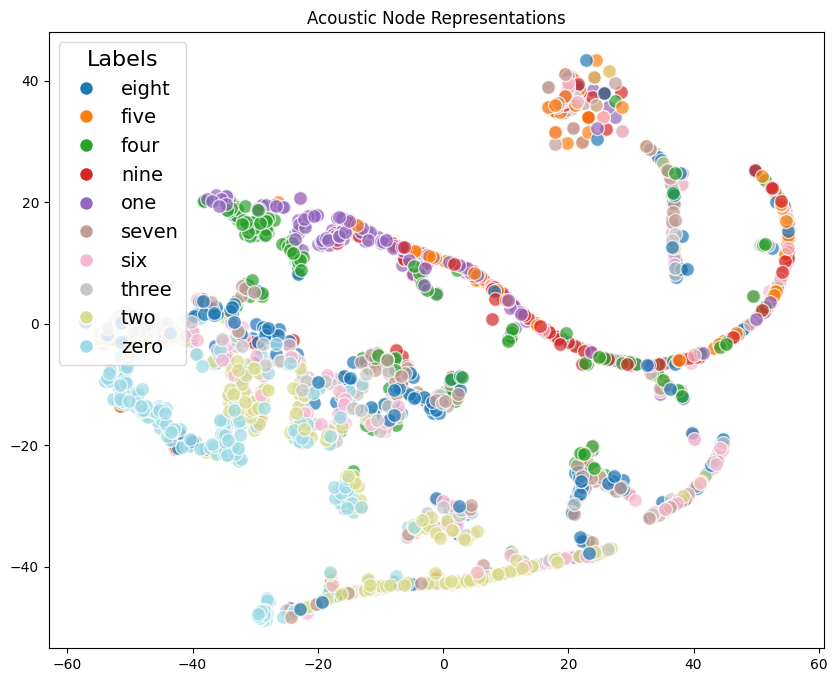

In [20]:
# Example usage

graph_file = 'saved_graphs/hetero_graph.dgl'
model_file = 'models'
label_name_file = 'label_names_spoken_digit.pkl'

hetero_graph = get_hetero_graph_file(dataset='spoken_digit',unit=3000,mhg='dnn', w=10)
load_and_plot_model(hetero_graph, model_file, label_name_file)

Extracting acoustic node representations...
Moyenne de similarité pour les éléments ayant le même label : 0.9050
Moyenne de similarité pour les éléments ayant des labels différents : 0.0429

Total Inertia per Label (Cosine Distance):
Label 0: 1.8961
Label 1: 1.2505
Label 2: 0.9796
Label 3: 1.2592
Label 4: 0.9456
Label 5: 0.4738
Label 6: 0.9699
Label 7: 0.8064


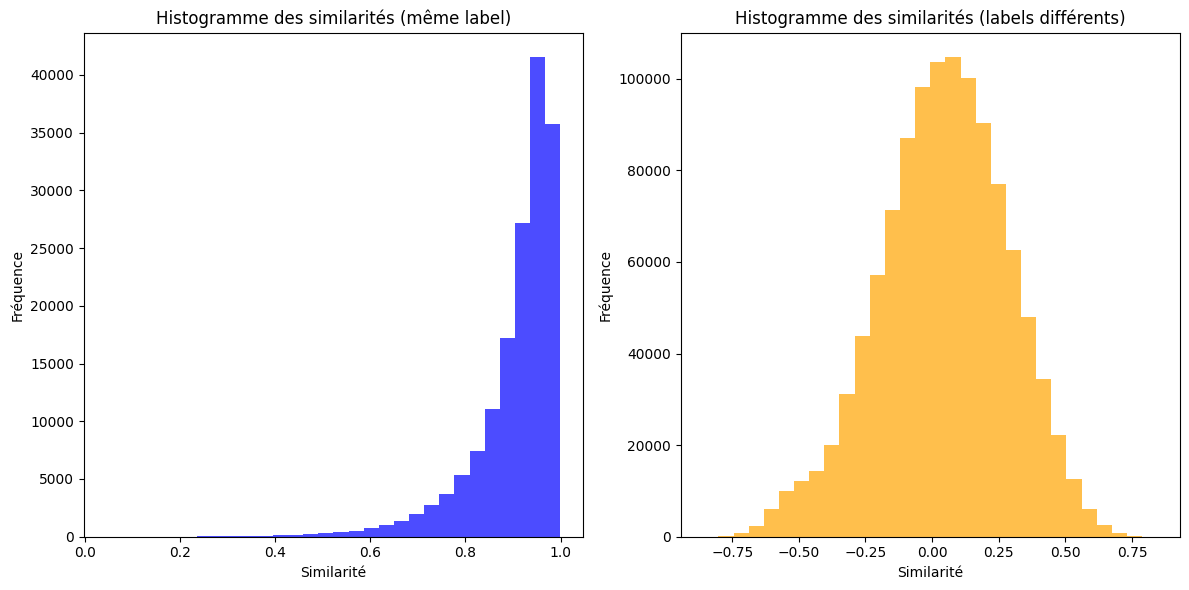

Total inertia: 1.0726


In [41]:
inertia_dic = plot_heatmap_similarity_hetero(hetero_graph, model_file)
T = 0
n_word = len(inertia_dic)
for label, inertia in inertia_dic.items():
        T +=inertia
T = T/n_word
print(f"Total intraclasse inertia: {T:.4f}")

Extracting acoustic node representations...
Moyenne de similarité pour les éléments ayant le même label : 0.6851
Moyenne de similarité pour les éléments ayant des labels différents : 0.5321

Total Inertia per Label (Cosine Distance):
Label 0: Total Inertia (Intraclass) = 30.0159
Label 1: Total Inertia (Intraclass) = 11.7445
Label 2: Total Inertia (Intraclass) = 23.0409
Label 3: Total Inertia (Intraclass) = 15.0510
Label 4: Total Inertia (Intraclass) = 26.5680
Label 5: Total Inertia (Intraclass) = 12.9417
Label 6: Total Inertia (Intraclass) = 31.0535
Label 7: Total Inertia (Intraclass) = 37.6697
Label 8: Total Inertia (Intraclass) = 13.4989
Label 9: Total Inertia (Intraclass) = 0.4992

Interclass Inertia (Cosine Distance) between centroids:
Interclass Inertia between Label 0 and Label 1: 0.1653
Interclass Inertia between Label 0 and Label 2: 0.0031
Interclass Inertia between Label 0 and Label 3: 0.0266
Interclass Inertia between Label 0 and Label 4: 0.0187
Interclass Inertia between Lab

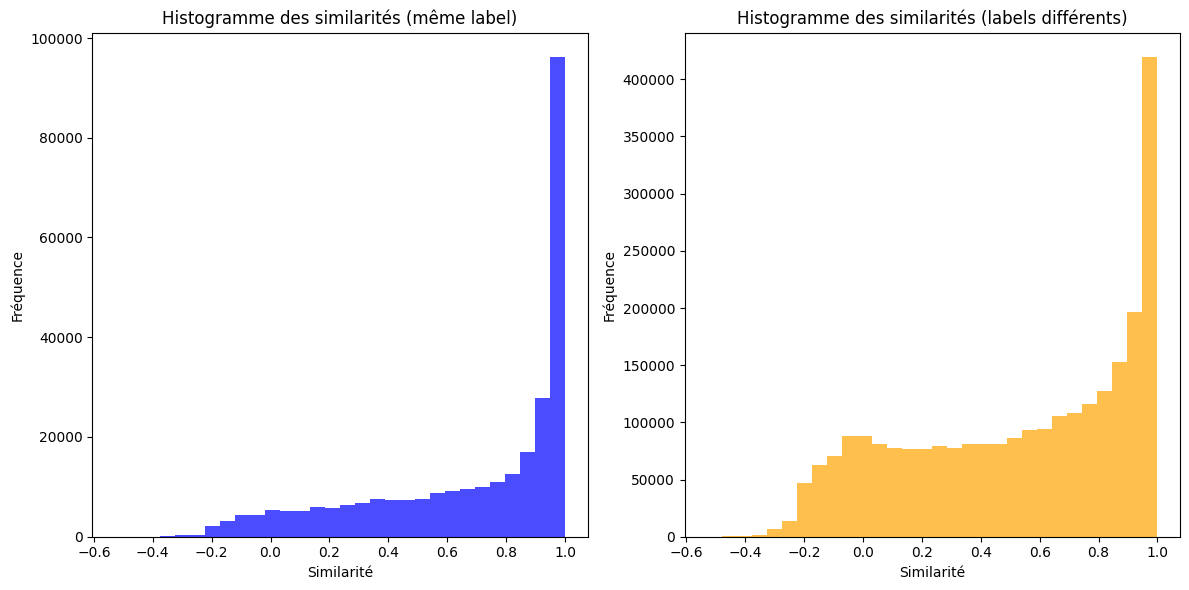

({0: 30.01592,
  1: 11.744453,
  2: 23.040928,
  3: 15.05098,
  4: 26.568039,
  5: 12.941665,
  6: 31.05351,
  7: 37.669724,
  8: 13.498874,
  9: 0.49920937},
 {0: 30.01592,
  1: 11.744453,
  2: 23.040928,
  3: 15.05098,
  4: 26.568039,
  5: 12.941665,
  6: 31.05351,
  7: 37.669724,
  8: 13.498874,
  9: 0.49920937},
 {(0, 1): 0.16527209,
  (0, 2): 0.0031303943,
  (0, 3): 0.026557319,
  (0, 4): 0.01868664,
  (0, 5): 0.022120714,
  (0, 6): 9.505934e-06,
  (0, 7): 2.5993372e-06,
  (0, 8): 0.0013014656,
  (0, 9): 0.007664624,
  (1, 2): 0.27466127,
  (1, 3): 0.0070997756,
  (1, 4): 0.20528154,
  (1, 5): 0.012728561,
  (1, 6): 0.122486666,
  (1, 7): 0.17285973,
  (1, 8): 0.32351306,
  (1, 9): 0.61618257,
  (2, 3): 0.044832245,
  (2, 4): 0.0010409576,
  (2, 5): 0.09988801,
  (2, 6): 0.0056466735,
  (2, 7): 0.005449682,
  (2, 8): 0.018060992,
  (2, 9): 0.012440112,
  (3, 4): 0.02902849,
  (3, 5): 0.006092596,
  (3, 6): 0.01752057,
  (3, 7): 0.032047644,
  (3, 8): 0.10111294,
  (3, 9): 0.207627

In [107]:
plot_heatmap_similarity_hetero(hetero_graph, model_file)

2024-10-25 14:58:39,518 - INFO - Extract acoustic node representations


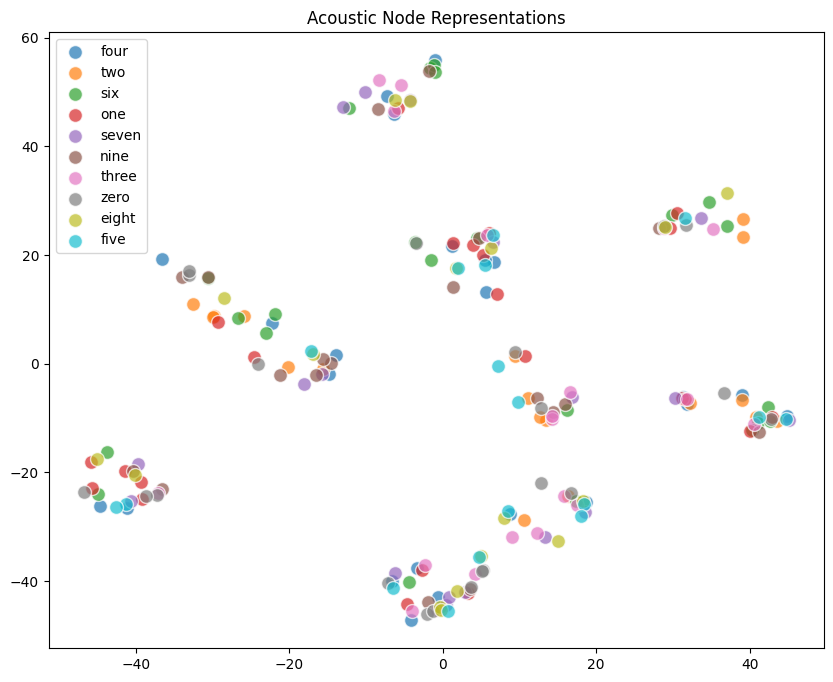

In [393]:
hetero_val_graph = get_hetero_val_graph_file(dataset='spoken_digit',unit=1000,mhg='dnn',pa=0.50,ph=0.50, w=10)
load_and_plot_model(hetero_val_graph, model_file, label_name_file,labels_val )

In [78]:

# Function to load the model and graph, get representations, and plot them
def load_and_plot_word(hetero_graph, model_folder, label_name_file):

    # Load label names
    with open( label_name_file, 'rb') as f:
        label_names = pickle.load(f)

    # Get labels and convert them to strings
    labels = hetero_graph.nodes['acoustic'].data['label']
    label_strings = [label_names[int(label)] for label in labels]
    
    # Load the heterogeneous GCN model
    features_dic = {
        'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
        'word': hetero_graph.nodes['word'].data['feat']
    }
    in_feats = {'acoustic': features_dic['acoustic'].shape[1], 'word': features_dic['word'].shape[1]}
    hidden_size = 512
    linear_hidden_size = 64
    out_feats = len(labels.unique())
    
    # Initialize the model
    model = HeteroGCN(in_feats, hidden_size, out_feats, linear_hidden_size)
    #model_sage = HeteroGCN(in_feats, hidden_size, out_feats)
    # Load the pre-trained model state
    model.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model.pth")))
    model.eval()
    
    #model_sage.load_state_dict(torch.load(os.path.join(model_folder, "hetero_gnn_model_unsupervised.pth")))
    #model_sage.eval()
    # Extract acoustic node representations
    logging.info(f'Extract acoustic node representations')
    with torch.no_grad():
        _,embeddings = model(hetero_graph, features_dic)
        word_embeddings = embeddings['word']

        
    

    # Get labels and convert them to strings for word nodes (if available)
    if 'label' in hetero_graph.nodes['word'].data:
        word_labels = hetero_graph.nodes['word'].data['label']
        word_label_strings = [label_names[int(label)] for label in word_labels]
    else:
        word_label_strings = ['word'] * len(word_embeddings)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)
# Plot the word node representations
    plt.figure(figsize=(10, 8))
    for label in set(word_label_strings):
        indices = [i for i, l in enumerate(word_label_strings) if l == label]
        plt.scatter(word_embeddings_2d[indices, 0], word_embeddings_2d[indices, 1], label=label, alpha=0.7)
        
   
    
    plt.legend()
    plt.title('Word Node Representations')
    plt.show()




In [ ]:
graph_file = 'saved_graphs/hetero_graph.dgl'
model_file = 'models'
label_name_file = 'label_names_google_command.pkl'

hetero_graph = get_hetero_graph_file(dataset='google_command',unit=1000,mhg='dnn')
load_and_plot_word(hetero_graph, model_file, label_name_file)

# Statistique descriptive

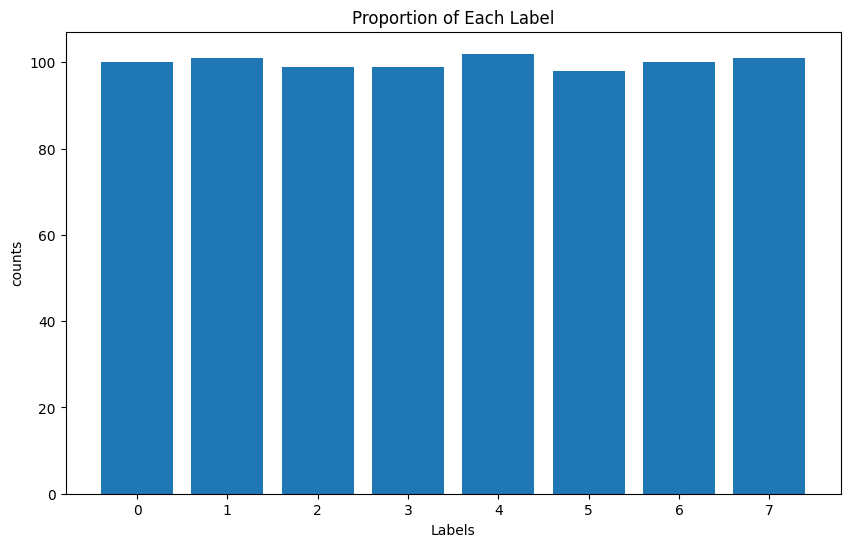

In [84]:
import torch
import matplotlib.pyplot as plt

# Assuming the tensor `labels` is already defined
# labels = tensor([1, 3, 2,  ..., 0, 3, 4])

# Count occurrences of each label
unique_labels, counts = torch.unique(labels, return_counts=True)

# Calculate proportions
proportions = counts.float() / counts.sum().float()

# Plotting the proportions
plt.figure(figsize=(10, 6))
plt.bar(unique_labels.numpy(), counts.numpy(), tick_label=unique_labels.numpy())
plt.xlabel('Labels')
plt.ylabel('counts')
plt.title('Proportion of Each Label')
plt.show()


In [104]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_weight(matrix_file,input_file='saved_matrix',mma='fixed'):
    # Assuming the adjacency matrix `adj_matrix` is already defined
    # Example of an adjacency matrix (this is a weighted graph)
    similarity_matrix = np.load(os.path.join(input_file,mma,matrix_file))
    adj_matrix = similarity_matrix
    # Calculate the degree of each node
    # Calculate the degree of each node
    degrees = np.count_nonzero(adj_matrix, axis=1)  # Sum of weights for each node (degree)
    
    # Extract all edge weights (excluding zeros)
    weights = adj_matrix[adj_matrix > 0]
    
    # Plot histogram of degrees
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(degrees, bins=len(degrees), edgecolor='black')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Histogram of Degrees')
    
    # Plot histogram of weights
    plt.subplot(1, 2, 2)
    plt.hist(weights, bins=10, edgecolor='black')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('Histogram of Weights')
    
    plt.tight_layout()
    plt.show()


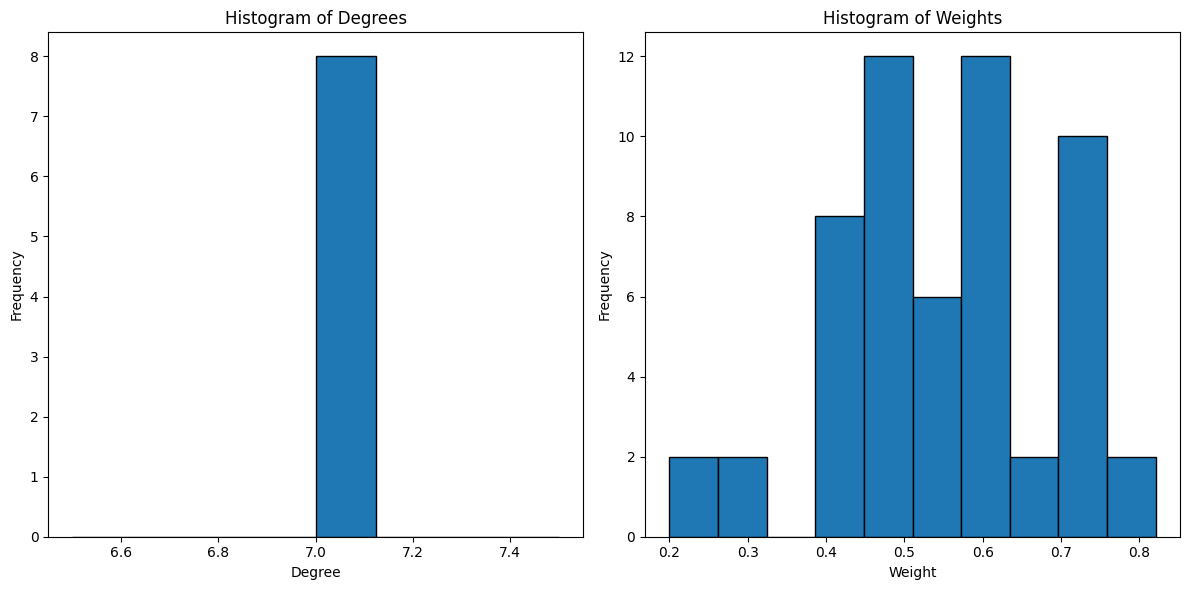

In [105]:
unit =1000
mma='fixed'
plot_degree_weight(input_file='',mma='',matrix_file=f'filtered_similarity_matrix_word.npy')




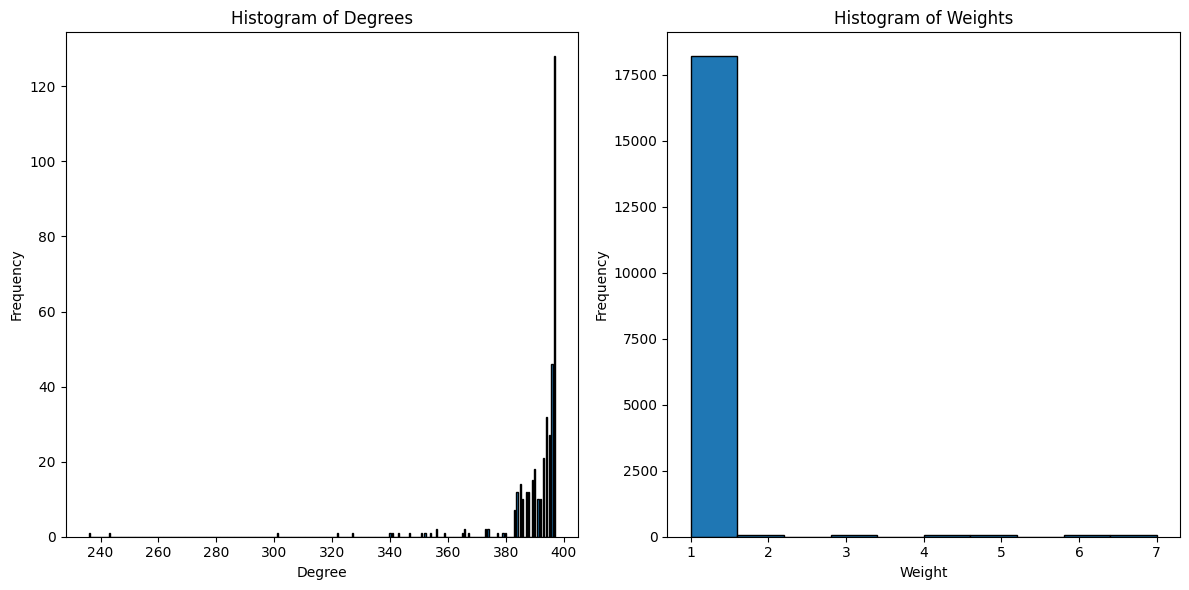

In [113]:
unit =500
mma='fixed'
plot_degree_weight(input_file='saved_matrix/google_command',matrix_file=f'filtered_matrix_with_labels_{unit}.npy')

Moyenne de similarité pour les éléments ayant le même label : 0.9255254029789839
Moyenne de similarité pour les éléments ayant des labels différents : -0.9829566559044545


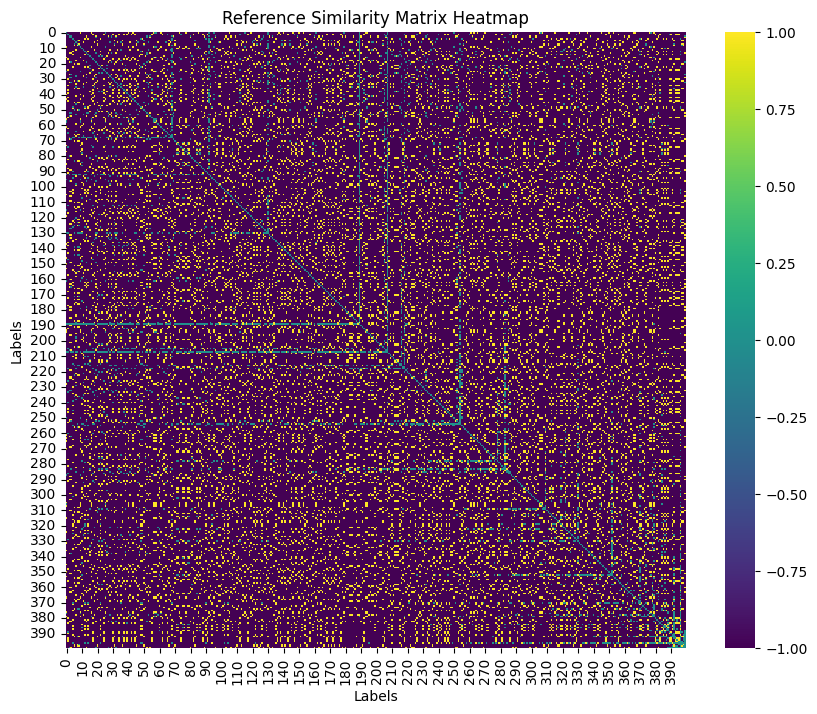

In [117]:
import seaborn as sns
matrix_dir = 'saved_matrix/google_command/fixed/'
# Charger la matrice
matrix_with_labels = np.load(os.path.join(matrix_dir, f'filtered_matrix_with_labels_500.npy'))

# Extraire les labels et la matrice de similarité
labels = matrix_with_labels[:, 0]  # Supposant que la première colonne contient les labels
similarity_matrix = matrix_with_labels[:, 1:]  # Le reste est la matrice de similarité

# Initialiser des listes pour stocker les similarités
same_label_similarities = []
diff_label_similarities = []

# Parcourir la matrice pour séparer les similarités selon les labels
for i in range(len(labels)):
    for j in range(i+1, len(labels)):  # Éviter de dupliquer les paires (par ex. (i, j) et (j, i))
        if labels[i] == labels[j]:
            same_label_similarities.append(similarity_matrix[i, j])  # Même label
        else:
            diff_label_similarities.append(similarity_matrix[i, j])  # Différent label

# Calculer les moyennes
mean_same_label = np.mean(same_label_similarities)
mean_diff_label = np.mean(diff_label_similarities)

# Afficher les résultats
print(f"Moyenne de similarité pour les éléments ayant le même label : {mean_same_label}")
print(f"Moyenne de similarité pour les éléments ayant des labels différents : {mean_diff_label}")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="viridis", annot=False)
plt.title("Reference Similarity Matrix Heatmap")
plt.xlabel("Labels")
plt.ylabel("Labels")
plt.show()


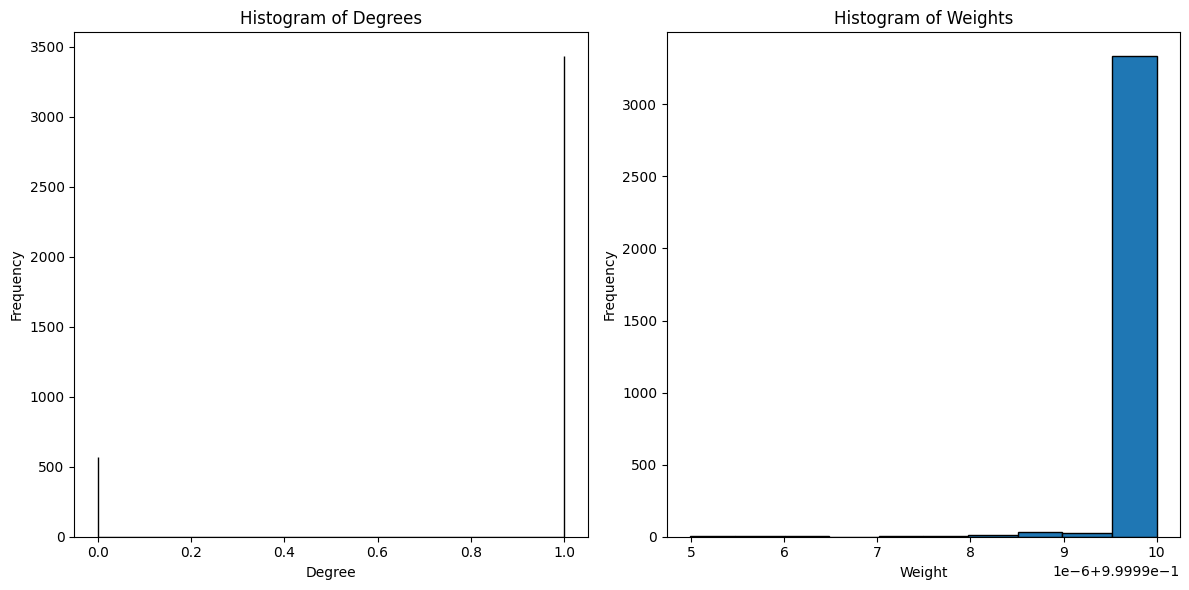

In [108]:
unit =1000
mma='fixed'
plot_degree_weight(input_file='',mma='',matrix_file=f'filtered_softmax_probabilities_words_acoustic.npy)